# DoWhy: Doubly robust estimator for causal effect estimation

This notebook shows how the doubly robust estimator in doWhy can be used for causal effect estimation.

The doubly robust estimator is a powerful technique in causal inference that combines the strengths of both outcome regression and propensity score methods to provide more accurate and reliable estimates of causal effects. By leveraging models for both the treatment assignment and the outcome, this method remains consistent if at least one of these models is correctly specified, offering robustness against model misspecification. 

### 0. Import required libraries

In [58]:
import pandas as pd
import numpy as np

import dowhy
from dowhy import CausalModel
import dowhy.datasets 


### 1. Load data


In this notebook, we'll be using the [Learning mindset dataset from Athey et al.](https://arxiv.org/pdf/1902.07409), which explores the impact of a growth mindset intervention on students' academic performance. The dataset includes information on various student characteristics, such as demographics and baseline academic performance, as well as details about the intervention and its outcomes. By analyzing this dataset, we aim to estimate the causal effect of the mindset intervention on students' subsequent grades. 

In [59]:
data = pd.read_csv("./learning_mindset.csv")


In [60]:
data.head()

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,76,1,0.277359,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.449646,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.769703,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.121763,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,1.526147,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757


Here we cleanup unncessary columns from our dataset

In [61]:
categorical = ["ethnicity", "gender", "school_urbanicity"]
continuous = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

cleaned_data = pd.concat([
    data.drop(columns=categorical),
    pd.get_dummies(data[categorical], columns=categorical, drop_first=False) 
], axis=1)

print(cleaned_data.shape)


(10391, 32)


### 2. Create a causal graph

Here, we define our assumptions in the form fo a causal gprah. This graph represents the relationships between the variables in our dataset and encodes our prior knowledge about the causal mechanisms at play.

In [62]:
causal_graph = """
    digraph causal_graph {
    schoolid;
    intervention;
    achievement_score;
    success_expect;
    ethnicity;
    gender;
    frst_in_family;
    school_urbanicity;
    school_mindset;
    school_achievement;
    school_ethnic_minority;
    school_poverty;
    school_size;
    intervention -> achievement_score;
    intervention -> success_expect;
    ethnicity -> achievement_score;
    gender -> achievement_score;
    frst_in_family -> achievement_score;
    school_urbanicity -> achievement_score;
    school_mindset -> achievement_score;
    school_achievement -> achievement_score;
    school_ethnic_minority -> achievement_score;
    school_poverty -> achievement_score;
    school_size -> achievement_score;
    school_mindset -> school_achievement;
}"""

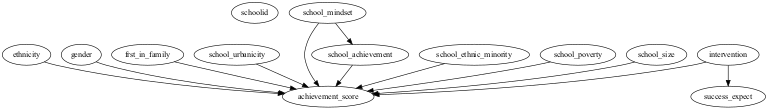

In [63]:
model= dowhy.CausalModel(
        data = cleaned_data,
        graph=causal_graph.replace("\n", " "),
        treatment="intervention",
        outcome="achievement_score")

model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### 2. Identify effect

In [64]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                             
───────────────(E[achievement_score])
d[intervention]                      
Estimand assumption 1, Unconfoundedness: If U→{intervention} and U→achievement_score then P(achievement_score|intervention,,U) = P(achievement_score|intervention,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### 3. Estimate the identified estimand with the doubly robust estimator

In [65]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="doubly_robust_estimator")

IndexError: list index out of range

### 4. Refute results

TODO: Write description on refuting results from doubly robust estimator

In [ ]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

NameError: name 'estimate' is not defined